In [97]:
# Imports:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import dxchange
import nibabel as nib
import tifffile
from skimage.filters import threshold_otsu
import localthickness as lt
os.chdir('/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project')

In [98]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/group01/Lava_data/Island_ny/'
file_name = 'lavasten_Island_ny_LFOV-80kV-LE2-1.8s-21.8micro_recon.txm'
absolute_path = os.path.join(folder_path, file_name)
all_data = dxchange.reader.read_txm(absolute_path)

In [99]:
print(all_data[1].keys())
data = all_data[0]
pixel_size = all_data[1]['pixel_size']
print(pixel_size)
img_shape = data.shape
print(img_shape)
img_shape_array = np.array(img_shape)
total_size = img_shape_array * pixel_size
total_size__mm = total_size/1000
print(total_size__mm)
pixel_size_mm = pixel_size/1000
pixels_per_mm = 1/pixel_size_mm
print(pixels_per_mm)

dict_keys(['facility', 'image_width', 'image_height', 'data_type', 'number_of_images', 'pixel_size', 'reference_filename', 'reference_data_type', 'thetas', 'x_positions', 'y_positions', 'z_positions', 'x-shifts', 'y-shifts', 'reference'])
21.822635650634766
(1018, 1024, 1004)
[22.21544309 22.34637891 21.90992619]
45.823979101759534


In [100]:
folder_path = '/dtu/3d-imaging-center/courses/02509/groups/members/s194333/HPC3D_project/results'
file_name = 'bin_data.tiff'
absolute_path = os.path.join(folder_path, file_name)
bin_data = tifffile.imread(absolute_path)

file_name = 'mask.tiff'
absolute_path = os.path.join(folder_path, file_name)
mask = tifffile.imread(absolute_path)

In [101]:
print(bin_data.shape, mask.shape)

(1018, 1024, 1004) (1018, 1024, 1004)


In [102]:
# crop 5mm times 5mm times 5mm
crop_size = int(5*pixels_per_mm)
if crop_size % 2 != 0:
    crop_size += 1
print(crop_size)

230


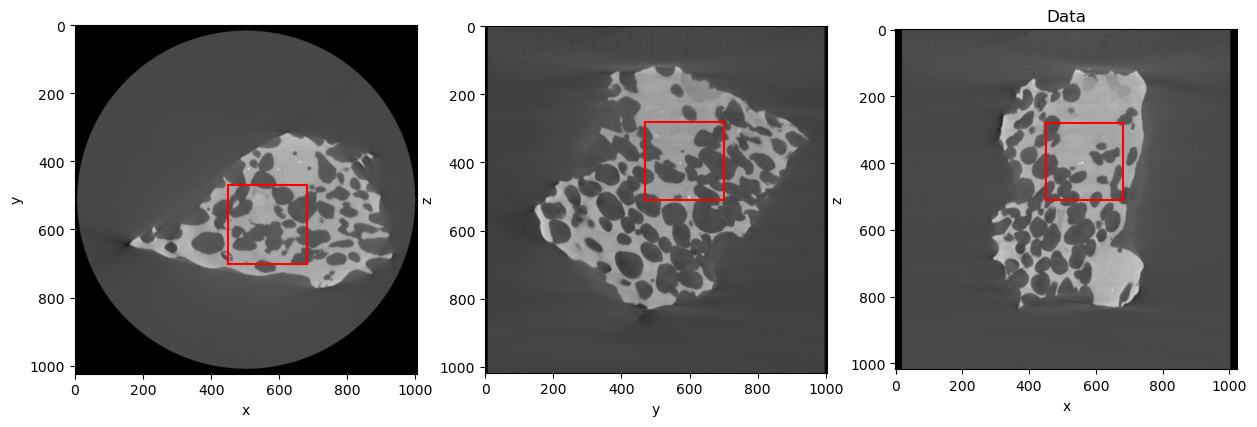

In [103]:
# visualize the data
start_x = 450#440
end_x = start_x + crop_size
start_y = 470#420
end_y = start_y + crop_size
start_z = 280#280
end_z = start_z + crop_size
slice = 100# crop_size
slice_x = start_x + slice
slice_y = start_y + slice
slice_z = start_z + slice
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(data[slice_z, :, :], cmap='gray')
# visualize the crop box
ax[0].plot([start_x, end_x], [start_y, start_y], 'r')
ax[0].plot([start_x, end_x], [end_y, end_y], 'r')
ax[0].plot([start_x, start_x], [start_y, end_y], 'r')
ax[0].plot([end_x, end_x], [start_y, end_y], 'r')
# ad axes labels
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].imshow(data[:,slice_x, :], cmap='gray')
ax[1].plot([start_y, end_y], [start_z, start_z], 'r')
ax[1].plot([start_y, end_y], [end_z, end_z], 'r')
ax[1].plot([start_y, start_y], [start_z, end_z], 'r')
ax[1].plot([end_y, end_y], [start_z, end_z], 'r')
ax[1].set_xlabel('y')
ax[1].set_ylabel('z')
ax[2].imshow(data[:, :, slice_y], cmap='gray')
ax[2].plot([start_x, end_x], [start_z, start_z], 'r')
ax[2].plot([start_x, end_x], [end_z, end_z], 'r')
ax[2].plot([start_x, start_x], [start_z, end_z], 'r')
ax[2].plot([end_x, end_x], [start_z, end_z], 'r')
ax[2].set_xlabel('x')
ax[2].set_ylabel('z')
plt.title('Data')
plt.show()

In [104]:
sample = data[start_z:end_z, start_x:end_x, start_y:end_y]
bin_sample = bin_data[start_z:end_z, start_x:end_x, start_y:end_y]
mask_sample = mask[start_z:end_z, start_x:end_x, start_y:end_y]
print(sample.shape, bin_sample.shape, mask_sample.shape)

(230, 230, 230) (230, 230, 230) (230, 230, 230)


In [105]:
def get_thickness(bin_sample, mask_sample, pixel_size):
    # get the local thickness
    local_thickness = lt.local_thickness(bin_sample, mask=mask_sample)
    thickness_true = 2*local_thickness
    # we want it in real world units
    thickness_true *= pixel_size

    return thickness_true

def get_statistics(bin_sample, mask_sample, pixel_size):
    # get ratio
    ratio = np.sum(bin_sample)/np.sum(mask_sample)

    # get the local thickness
    thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
    thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

    # get the mean thickness
    mean_thickness_stone = np.mean(thickness_stone[thickness_stone > 0])
    mean_thickness_bubbles = np.mean(thickness_bubbles[thickness_bubbles > 0])

    # get median thickness
    median_thickness_stone = np.median(thickness_stone[thickness_stone > 0])
    median_thickness_bubbles = np.median(thickness_bubbles[thickness_bubbles > 0])
    
    return [ratio, mean_thickness_stone, mean_thickness_bubbles, median_thickness_stone, median_thickness_bubbles]

In [106]:
ratio, mean_thickness_stone, mean_thickness_bubbles, median_thickness_stone, median_thickness_bubbles = get_statistics(bin_sample, mask_sample, pixel_size)

print(f'ratio: {ratio}')
print(f'mean thickness stone: {mean_thickness_stone}')
print(f'mean thickness bubbles: {mean_thickness_bubbles}')
print(f'median thickness stone: {median_thickness_stone}')
print(f'median thickness bubbles: {median_thickness_bubbles}')


ratio: 0.5399792882386784
mean thickness stone: 1128.4749755859375
mean thickness bubbles: 895.7265625
median thickness stone: 914.6321411132812
median thickness bubbles: 868.6622924804688


In [107]:
thickness_stone = get_thickness(bin_sample, mask_sample, pixel_size)
thickness_bubbles = get_thickness(1-bin_sample, mask_sample, pixel_size)

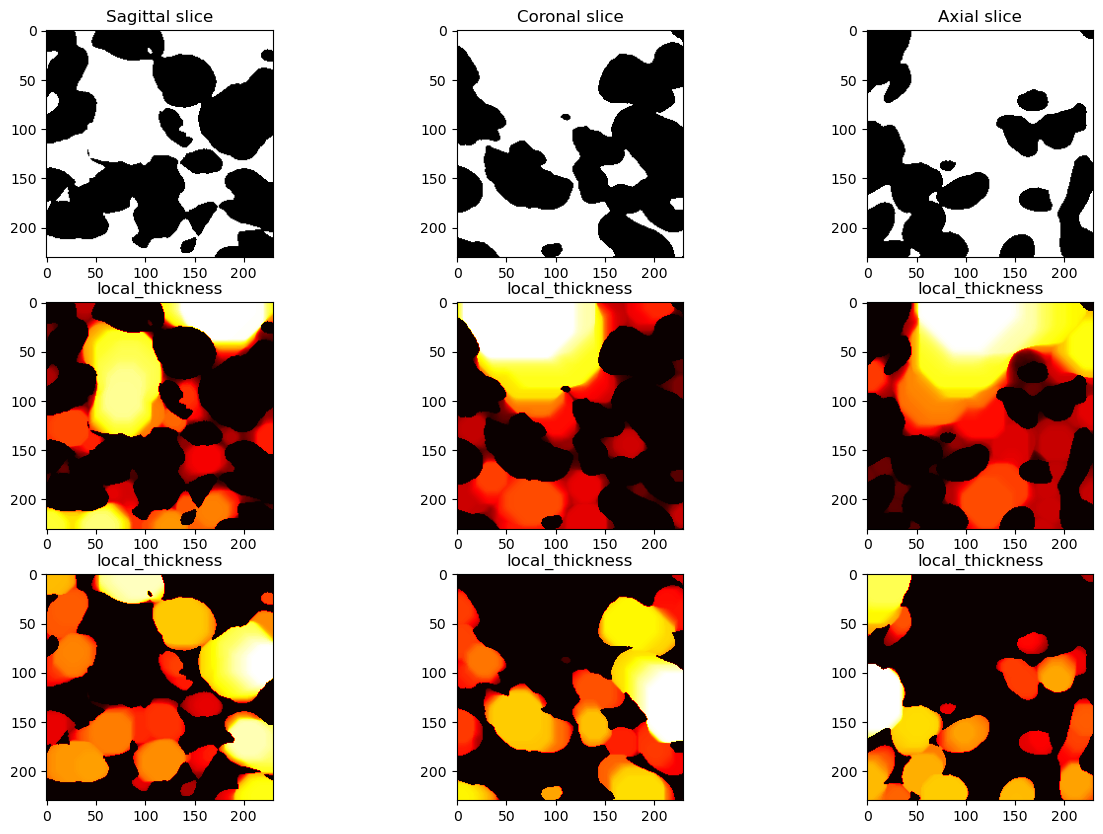

In [108]:
slice_n = 100

#----------------Sagittal slice----------------
fig, ax = plt.subplots(3,3,figsize=(15,10))
ax[0][0].imshow(np.squeeze(bin_sample[slice_n,:,:]), cmap='gray')
ax[0][0].set_title('Sagittal slice')

ax[1][0].imshow(np.squeeze(thickness_stone[slice_n,:,:]), cmap='hot')
ax[1][0].set_title('local_thickness')

ax[2][0].imshow(np.squeeze(thickness_bubbles[slice_n,:,:]), cmap='hot')
ax[2][0].set_title('local_thickness')


#----------------Coronal view----------------

ax[0][1].imshow(np.squeeze(bin_sample[:,slice_n,:]), cmap='gray')
ax[0][1].set_title('Coronal slice')

ax[1][1].imshow(np.squeeze(thickness_stone[:,slice_n,:]), cmap='hot')
ax[1][1].set_title('local_thickness')

ax[2][1].imshow(np.squeeze(thickness_bubbles[:,slice_n,:]), cmap='hot')
ax[2][1].set_title('local_thickness')


#----------------Axial view----------------

ax[0][2].imshow(np.squeeze(bin_sample[:,:,slice_n]), cmap='gray')
ax[0][2].set_title('Axial slice')

ax[1][2].imshow(np.squeeze(thickness_stone[:,:,slice_n]), cmap='hot')
ax[1][2].set_title('local_thickness')

ax[2][2].imshow(np.squeeze(thickness_bubbles[:,:,slice_n]), cmap='hot')
ax[2][2].set_title('local_thickness')

plt.show()